In [36]:
# Box 1 — Imports & Config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Config
STOCK_PATH   = "clean_stock_data.csv"
MENTION_PATH = "bluesky_merged_mentions.csv"
ROLL_WIN     = 7


In [37]:
# Box 2 — Load & Merge
stock = pd.read_csv(STOCK_PATH)
mentions = pd.read_csv(MENTION_PATH)

# Clean columns
stock.columns = stock.columns.str.strip()
mentions.columns = mentions.columns.str.strip()

stock["Date"] = pd.to_datetime(stock["Date"])
mentions["date"] = pd.to_datetime(mentions["date"])
stock["Ticker"] = stock["Ticker"].astype(str).str.upper().str.strip()
mentions["company"] = mentions["company"].astype(str).str.upper().str.strip()

df = stock.merge(
    mentions,
    left_on=["Ticker","Date"],
    right_on=["company","date"],
    how="left"
)
df = df.sort_values(["Ticker","Date"]).reset_index(drop=True)
print(f"Rows: {len(df):,} | Tickers: {df['Ticker'].nunique()}")
df.head(3)


Rows: 33,690 | Tickers: 49


,Date,Ticker,Close,log_return,weekly_variance,monthly_variance,company,date,all_keywords_mentions,ticker_mentions,ceo_mentions
0,2023-01-03,AAPL,123.330650,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,2023-01-04,AAPL,124.602715,0.010261,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,2023-01-05,AAPL,123.281334,-0.010661,NaN,NaN,NaN,NaT,NaN,NaN,NaN


In [38]:
# Box 3 — Select numeric columns for PCA
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric columns ({len(numeric_cols)}):", numeric_cols[:10])

# Drop non-informative or identifier columns
drop_cols = ["Unnamed: 0", "Date", "fwd5_log_return", "fwd5_abs_return"] if "fwd5_log_return" in df else ["Unnamed: 0"]
cols = [c for c in numeric_cols if c not in drop_cols]
data = df[cols].fillna(0)
print("Final features for PCA:", len(cols))


Numeric columns (7): ['Close', 'log_return', 'weekly_variance', 'monthly_variance', 'all_keywords_mentions', 'ticker_mentions', 'ceo_mentions']
Final features for PCA: 7


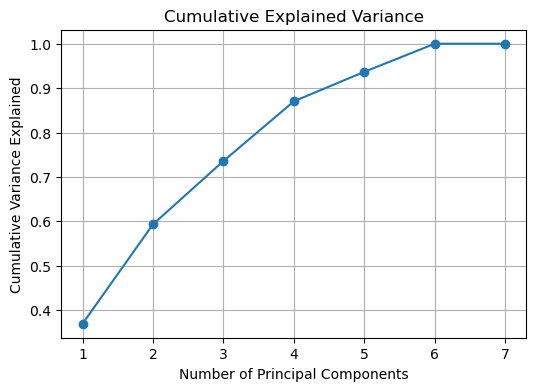

,Component,ExplainedVariance,Cumulative
0,PC1,0.369386,0.369386
1,PC2,0.223850,0.593236
2,PC3,0.142580,0.735816
3,PC4,0.134495,0.870311
4,PC5,0.066444,0.936755
5,PC6,0.063243,0.999998
6,PC7,0.000002,1.000000


In [39]:
# Box 4 — Standardize & Fit PCA
scaler = StandardScaler()
scaled = scaler.fit_transform(data)

pca = PCA(n_components=min(10, scaled.shape[1]))
pca.fit(scaled)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained)+1), cum_explained, marker="o")
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

pd.DataFrame({
    "Component": [f"PC{i+1}" for i in range(len(explained))],
    "ExplainedVariance": explained,
    "Cumulative": cum_explained
})


In [40]:
# Box 5 — Loadings (top features per component)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=cols
)

# Show top 10 for PC1 and PC2
for i in range(2):
    comp = f"PC{i+1}"
    top = loadings[comp].abs().sort_values(ascending=False).head(10)
    print(f"\nTop 10 features driving {comp}:")
    display(top)



Top 10 features driving PC1:


all_keywords_mentions    0.603761
ticker_mentions          0.597152
ceo_mentions             0.495665
Close                    0.180327
monthly_variance         0.020489
weekly_variance          0.016165
log_return               0.000433
Name: PC1, dtype: float64


Top 10 features driving PC2:


monthly_variance         0.699352
weekly_variance          0.699101
Close                    0.119080
log_return               0.089244
ceo_mentions             0.003130
all_keywords_mentions    0.002290
ticker_mentions          0.002112
Name: PC2, dtype: float64

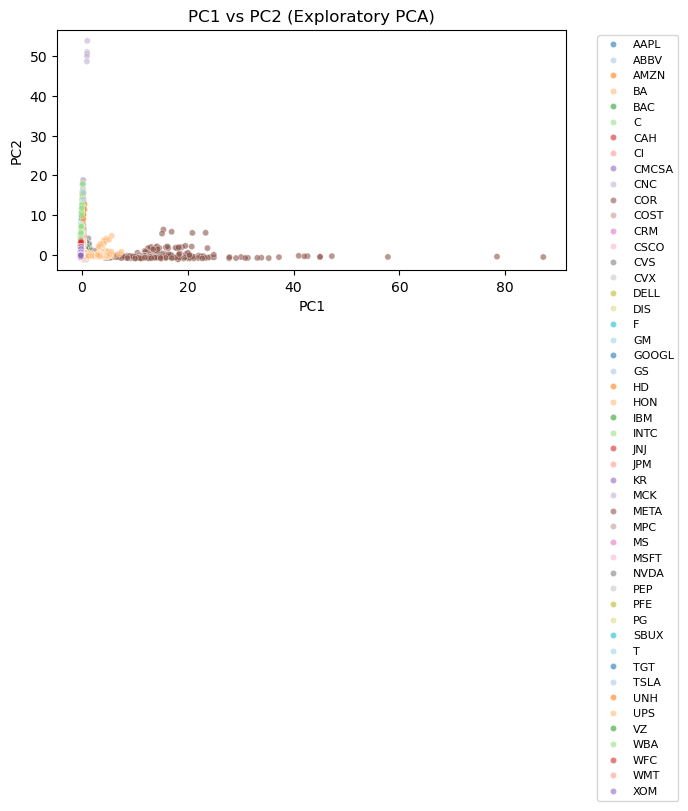

In [41]:
# Box 6 — Scatter Plot of PC1 vs PC2
pca_df = pd.DataFrame(pca.transform(scaled), columns=[f"PC{i+1}" for i in range(pca.n_components_)])
pca_df["Ticker"] = df["Ticker"].values

plt.figure(figsize=(7,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Ticker", alpha=0.6, s=20, palette="tab20")
plt.title("PC1 vs PC2 (Exploratory PCA)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', ncol=1, fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
# Box 1 — Imports & Config 0 for mentions, knn for stocks
import numpy as np
import pandas as pd

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

STOCK_PATH   = "clean_stock_data.csv"
MENTION_PATH = "bluesky_merged_mentions.csv"

# how many PCs to compute (cap at #features later)
N_PCS = 10


In [43]:
# Box 2 — Load & Merge
stock = pd.read_csv(STOCK_PATH)
mentions = pd.read_csv(MENTION_PATH)

stock.columns    = stock.columns.str.strip()
mentions.columns = mentions.columns.str.strip()

stock["Date"]   = pd.to_datetime(stock["Date"])
mentions["date"] = pd.to_datetime(mentions["date"])

stock["Ticker"]   = stock["Ticker"].astype(str).str.upper().str.strip()
mentions["company"] = mentions["company"].astype(str).str.upper().str.strip()

df = stock.merge(
    mentions,
    left_on=["Ticker","Date"],
    right_on=["company","date"],
    how="left"
).sort_values(["Ticker","Date"]).reset_index(drop=True)

print(f"Rows: {len(df):,} | Tickers: {df['Ticker'].nunique()}")
df.head(3)


Rows: 33,690 | Tickers: 49


,Date,Ticker,Close,log_return,weekly_variance,monthly_variance,company,date,all_keywords_mentions,ticker_mentions,ceo_mentions
0,2023-01-03,AAPL,123.330650,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,2023-01-04,AAPL,124.602715,0.010261,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,2023-01-05,AAPL,123.281334,-0.010661,NaN,NaN,NaN,NaT,NaN,NaN,NaN


In [ ]:
# Box 3 — Mentions: fillna(0); Stock: KNN impute

# identify mentions columns (pattern-based + common names)
def is_mentions_col(c: str) -> bool:
    cl = c.lower()
    keys = ["mention", "post", "repost", "quote", "reply", "like", "hashtag", "karma"]
    return any(k in cl for k in keys)

mentions_cols = [c for c in df.columns if is_mentions_col(c)]
# include known columns explicitly if present
for c in ["all_keywords_mentions", "ticker_mentions", "ceo_mentions"]:
    if c in df.columns and c not in mentions_cols:
        mentions_cols.append(c)

# numeric columns overall
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# stock numeric = numeric minus mentions numeric and minus ids/leaks
non_feature = set(["Date", "date"])  # will be dropped anyway later
stock_num_cols = [c for c in num_cols if c not in mentions_cols and c not in non_feature]

print(f"Mentions cols ({len(mentions_cols)}): {mentions_cols[:8]}")
print(f"Stock numeric cols ({len(stock_num_cols)}): {stock_num_cols[:8]}")

# 1) Mentions → fillna(0)
if mentions_cols:
    df[mentions_cols] = df[mentions_cols].fillna(0)

# 2) Stock numerics → KNNImputer (fit on available rows)
if stock_num_cols:
    imputer = KNNImputer(n_neighbors=5, weights="distance")
    df[stock_num_cols] = imputer.fit_transform(df[stock_num_cols])

# quick NA check
na_left = df[mentions_cols + stock_num_cols].isna().sum().sum()
print(f"Remaining NaNs in mentions+stock feature set: {na_left}")


Mentions cols (3): ['all_keywords_mentions', 'ticker_mentions', 'ceo_mentions']
Stock numeric cols (4): ['Close', 'log_return', 'weekly_variance', 'monthly_variance']
Remaining NaNs in mentions+stock feature set: 0
Rows: 33,690 | Tickers: 49


,Date,Ticker,Close,log_return,weekly_variance,monthly_variance,company,date,all_keywords_mentions,ticker_mentions,ceo_mentions
0,2023-01-03,AAPL,123.330650,-0.004326,0.000532,0.000594,NaN,NaT,0.0,0.0,0.0
1,2023-01-04,AAPL,124.602715,0.010261,0.001526,0.000647,NaN,NaT,0.0,0.0,0.0
2,2023-01-05,AAPL,123.281334,-0.010661,0.000357,0.000855,NaN,NaT,0.0,0.0,0.0


In [45]:
# Box 4 — Build matrix, scale, PCA

# choose features for PCA = all numeric except obvious IDs/dates
drop_cols = set(["Date"])  # 'date' from mentions already merged, numeric-only filter ignores strings
pca_feature_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in drop_cols]

X = df[pca_feature_cols].to_numpy()
print(f"PCA features: {len(pca_feature_cols)} | Shape: {X.shape}")

# scale
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

# PCA
n_pcs = min(N_PCS, Xz.shape[1])
pca = PCA(n_components=n_pcs, random_state=42)
X_pcs = pca.fit_transform(Xz)

expl = pca.explained_variance_ratio_
cum  = np.cumsum(expl)
print(pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(n_pcs)],
    "ExplainedVar": expl,
    "Cumulative": cum
}).round(4))


PCA features: 7 | Shape: (33690, 7)
    PC  ExplainedVar  Cumulative
0  PC1        0.3694      0.3694
1  PC2        0.2240      0.5934
2  PC3        0.1426      0.7360
3  PC4        0.1344      0.8705
4  PC5        0.0664      0.9369
5  PC6        0.0631      1.0000
6  PC7        0.0000      1.0000


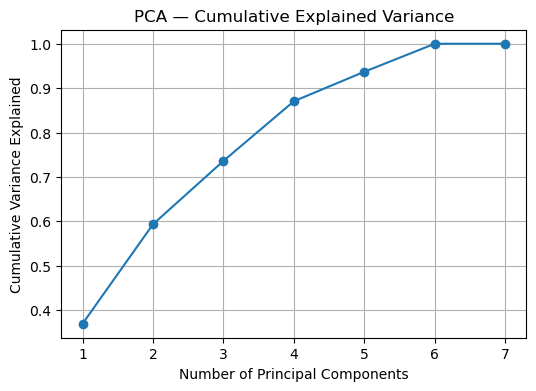

In [46]:
# Box 5 — Scree plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(cum)+1), cum, marker="o")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("PCA — Cumulative Explained Variance")
plt.grid(True)
plt.show()


In [47]:
# Box 6 — Top loadings for PC1 & PC2
loadings = pd.DataFrame(
    pca.components_.T,
    index=pca_feature_cols,
    columns=[f"PC{i+1}" for i in range(n_pcs)]
)

for i in range(min(2, n_pcs)):
    comp = f"PC{i+1}"
    top = loadings[comp].abs().sort_values(ascending=False).head(15)
    print(f"\nTop 15 absolute loadings — {comp}")
    display(top.to_frame("abs_loading"))



Top 15 absolute loadings — PC1


,abs_loading
all_keywords_mentions,0.603783
ticker_mentions,0.597173
ceo_mentions,0.495698
Close,0.180400
monthly_variance,0.018384
weekly_variance,0.015214
log_return,0.000346



Top 15 absolute loadings — PC2


,abs_loading
monthly_variance,0.699539
weekly_variance,0.698864
Close,0.122346
log_return,0.085229
ceo_mentions,0.001223
all_keywords_mentions,0.000764
ticker_mentions,0.000641


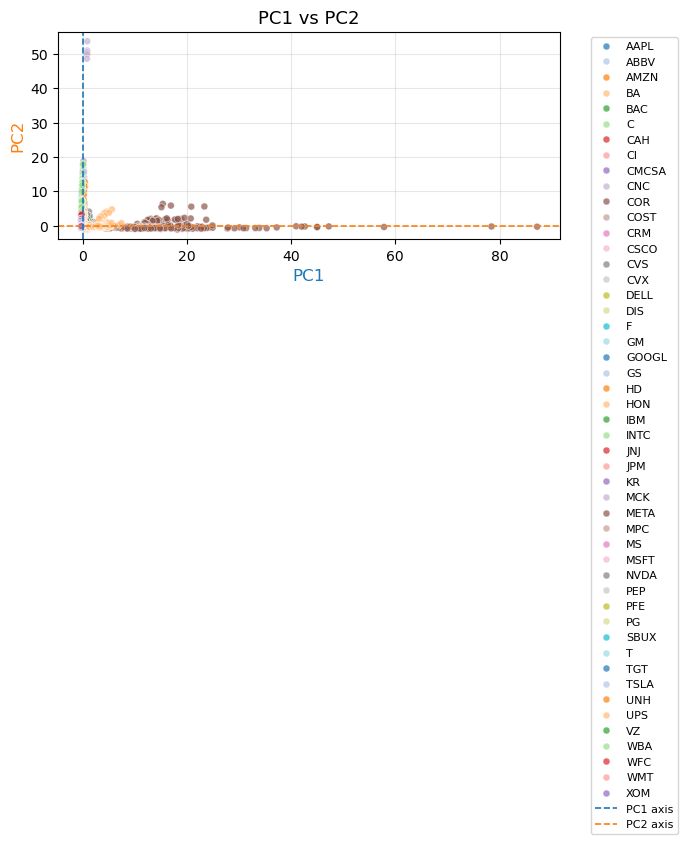

In [52]:
# Box 6 — Scatter Plot of PC1 vs PC2 with Distinct Axis Colors

pca_df = pd.DataFrame(
    pca.transform(scaled),
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
pca_df["Ticker"] = df["Ticker"].values

plt.figure(figsize=(7,6))

# draw scatter by ticker as before
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2",
    hue="Ticker", alpha=0.7, s=25, palette="tab20"
)

# emphasize axes: color PC1 axis blue, PC2 axis orange
plt.axvline(0, color="#1f77b4", lw=1.2, ls="--", label="PC1 axis")
plt.axhline(0, color="#ff7f0e", lw=1.2, ls="--", label="PC2 axis")

plt.xlabel("PC1", color="#1f77b4", fontsize=12)
plt.ylabel("PC2", color="#ff7f0e", fontsize=12)
plt.title("PC1 vs PC2", fontsize=13)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', ncol=1, fontsize=8)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()
